In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
def image_directory_to_pandas(image_path):
    """
    Generate a DataFrame with image paths and labels extracted from a directory structure.

    Parameters:
        image_path (str): Root directory containing labeled subfolders (family_genus_species).

    Returns:
        pd.DataFrame: DataFrame with columns ['image_path', 'folder_label', 'family', 'genus', 'species'].
    """
    data = []

    for root_dir, _, filenames in os.walk(image_path):
        folder_label = os.path.basename(root_dir)
        if folder_label == "GT":  # Skip ground-truth directories
            continue

        for filename in filenames:
            if filename.startswith('.') or not filename.lower().endswith(('jpeg', 'jpg', 'png')):
                continue
            data.append((os.path.join(root_dir, filename), folder_label))

    df = pd.DataFrame(data, columns=['image_path', 'folder_label'])

    try:
        df[['family', 'genus', 'species']] = df['folder_label'].str.split('_', expand=True)
        df['species'] = df['genus'] + " " + df['species']
    except ValueError:
        raise ValueError("Folder structure must follow the 'family_genus_species' format.")

    return df[['image_path', 'folder_label', 'family', 'genus', 'species']]

def split_image_dataframe(df, test_size=0.2, val_size=0.1, random_state=42, stratify_by='folder_label'):
    """
    Split a DataFrame into train, validation, and test sets.

    Parameters:
        df (pd.DataFrame): Input DataFrame with image paths and labels.
        test_size (float): Fraction of data for the test set.
        val_size (float): Fraction of data for the validation set.
        random_state (int): Random seed for reproducibility.
        stratify_by (str): Column to stratify splits by.

    Returns:
        tuple: (train_df, val_df, test_df)
    """
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, stratify=df[stratify_by], random_state=random_state
    )

    train_df, val_df = train_test_split(
        train_val_df, 
        test_size=val_size / (1 - test_size), 
        stratify=train_val_df[stratify_by], 
        random_state=random_state
    )

    return train_df, val_df, test_df

def process_image_and_labels(image_path, family, genus, species, family_labels, genus_labels, species_labels, image_size=(224, 224)):
    """
    Process an image and its corresponding labels.

    Parameters:
        image_path (str): Path to the image file.
        family, genus, species (str): Taxonomic labels.
        family_labels, genus_labels, species_labels (tf.Tensor): Unique labels for one-hot encoding.
        image_size (tuple): Target size for image resizing.

    Returns:
        tuple: (processed image, dict of one-hot encoded labels).
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)

    # One-hot encode labels
    labels = {
        "family": tf.one_hot(tf.argmax(family_labels == family), len(family_labels)),
        "genus": tf.one_hot(tf.argmax(genus_labels == genus), len(genus_labels)),
        "species": tf.one_hot(tf.argmax(species_labels == species), len(species_labels)),
    }

    return img, labels

def build_dataset_from_dataframe(df, batch_size=32, image_size=(224, 224)):
    """
    Build a TensorFlow dataset from a DataFrame of image paths and labels.

    Parameters:
        df (pd.DataFrame): DataFrame with ['image_path', 'family', 'genus', 'species'] columns.
        batch_size (int): Number of samples per batch.
        image_size (tuple): Target size for image resizing.

    Returns:
        tuple: (tf.data.Dataset, list of family labels, list of genus labels, list of species labels)
    """
    # Extract unique labels
    family_labels = tf.constant(sorted(df['family'].unique()))
    genus_labels = tf.constant(sorted(df['genus'].unique()))
    species_labels = tf.constant(sorted(df['species'].unique()))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['image_path'], df['family'], df['genus'], df['species'])
    )
    dataset = dataset.map(
        lambda path, family, genus, species: process_image_and_labels(
            path, family, genus, species, family_labels, genus_labels, species_labels, image_size
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.shuffle(len(df)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, family_labels.numpy().tolist(), genus_labels.numpy().tolist(), species_labels.numpy().tolist()

def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224, 224), top_k=3, verbose=1):
    """
    Predict the top-k family, genus, and species for an image.

    Parameters:
        image_path (str): Path to the image.
        model (tf.keras.Model): Trained model.
        family_labels, genus_labels, species_labels (list): Unique labels for decoding predictions.
        image_size (tuple): Target image size for resizing.
        top_k (int): Number of top predictions to return.

    Returns:
        tuple: (top_k_family, top_k_genus, top_k_species)
    """
    # Preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Model predictions
    family_pred, genus_pred, species_pred = model.predict(img, verbose=verbose)

    # Extract top-k predictions for each level
    def extract_top_k(preds, labels):
        top_k_indices = np.argsort(preds[0])[-top_k:][::-1]
        return [(labels[i], preds[0][i]) for i in top_k_indices]

    return (
        extract_top_k(family_pred, family_labels),
        extract_top_k(genus_pred, genus_labels),
        extract_top_k(species_pred, species_labels),
    )


In [3]:
df_images = image_directory_to_pandas(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=0.15,
    test_size=0.15,
    random_state=42,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

test_ds, _, _, _ = build_dataset_from_dataframe(test_df, batch_size=64, image_size=(384, 384))

2024-11-26 14:30:13.944223: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-26 14:30:13.944254: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-26 14:30:13.944258: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-26 14:30:13.944272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 14:30:13.944283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
model = tf.keras.models.load_model("/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras")

/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Saliency Maps

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def compute_saliency_maps(img_path, model, img_size=(384, 384)):
    """
    Compute and visualize saliency maps for the predicted class with the highest value 
    for family, genus, and species, displayed side-by-side with the original image.

    Args:
    - img_path (str): Path to the input image.
    - model (tf.keras.Model): Trained model with three outputs (family, genus, species).
    - img_size (tuple): Target image size for resizing.

    Returns:
    - None. Displays the saliency maps for family, genus, and species side-by-side with the original image.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_tensor = tf.convert_to_tensor(img_array)

    # Prepare the original image for display
    original_img = np.array(img) / 255.0  # Normalize to [0, 1]

    # Map output types to model output indices
    output_mapping = {'family': 0, 'genus': 1, 'species': 2}

    # Store saliency maps
    saliency_maps = {}

    # Generate saliency maps for each output type
    for output_type, output_index in output_mapping.items():
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            outputs = model(img_tensor)  # Multi-output prediction
            preds = outputs[output_index]
            class_indices = tf.argmax(preds, axis=-1)[0]  # Select class with the highest prediction value
            loss = preds[:, class_indices]

        grads = tape.gradient(loss, img_tensor)

        # Compute the mean of the absolute gradients across the color channels
        saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

        # Normalize the saliency map
        saliency = saliency.numpy()
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())  # Normalize to [0, 1]

        # Store the saliency map
        saliency_maps[output_type] = saliency

    # Plot the original image and saliency maps
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 4, 1)
    plt.imshow(original_img)
    plt.axis('off')
    plt.title("Original Image")

    for i, (output_type, saliency) in enumerate(saliency_maps.items(), start=2):
        plt.subplot(1, 4, i)
        #plt.imshow(original_img)
        plt.imshow(saliency, cmap='jet', alpha=1)
        plt.axis('off')
        plt.title(f"{output_type.capitalize()} Saliency")

    plt.tight_layout()
    plt.show()

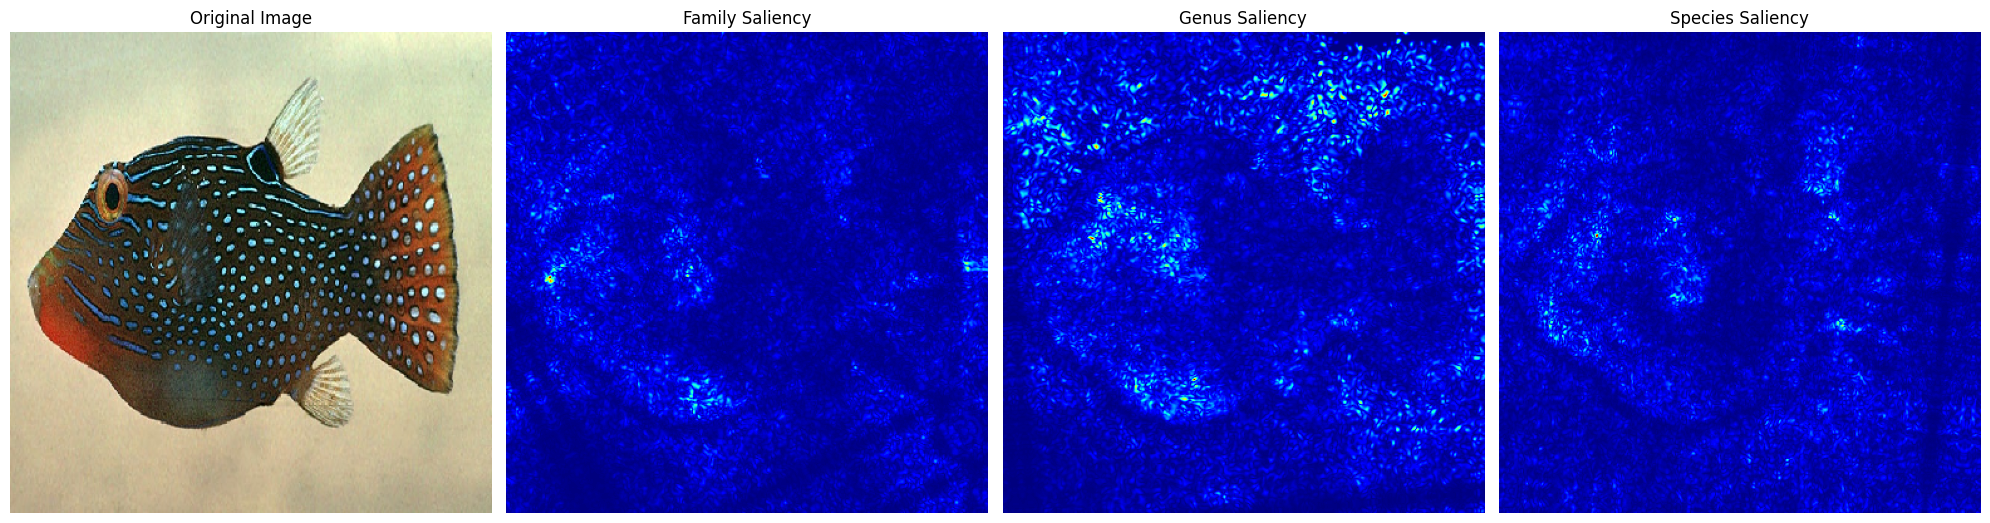

In [8]:
img_path = test_df['image_path'].values[0]

# Visualize saliency maps side-by-side
compute_saliency_maps(img_path, model)

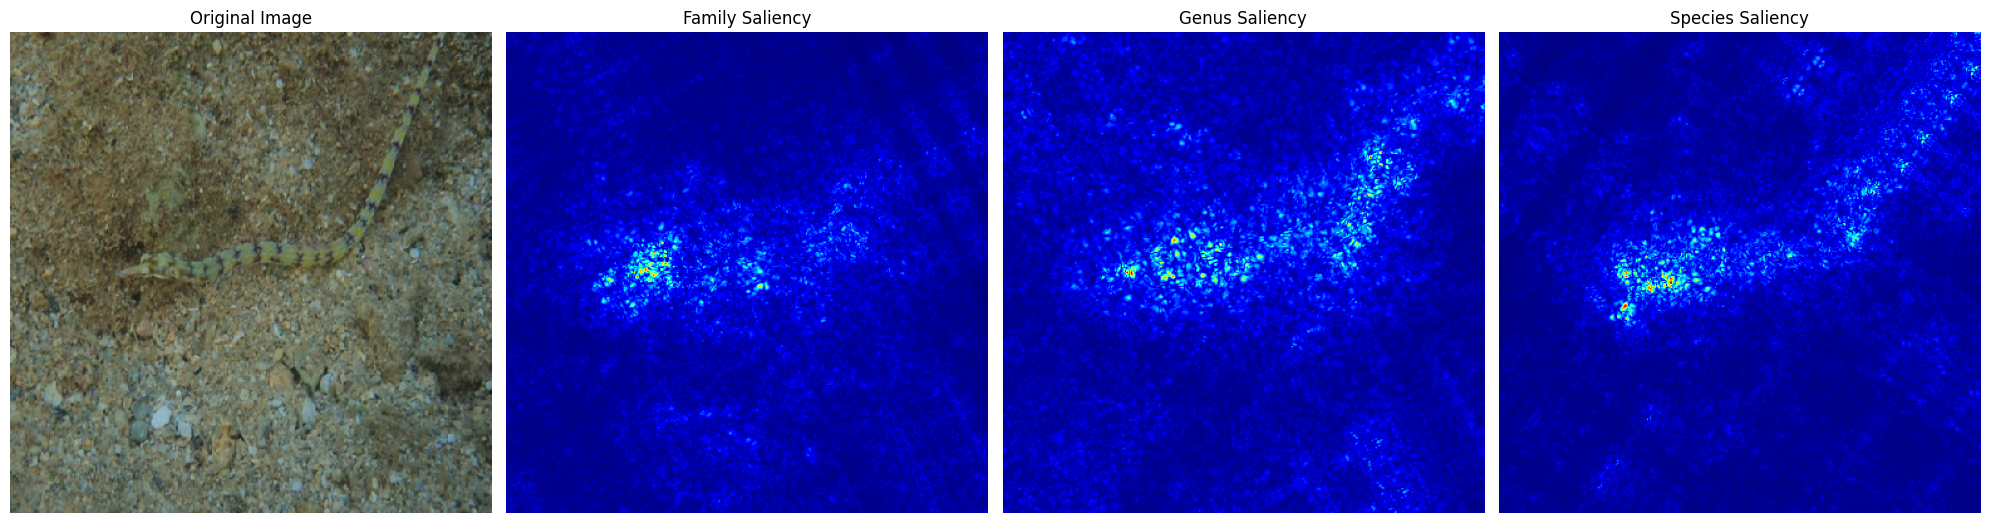

In [9]:
img_path = test_df['image_path'].values[700]

# Visualize saliency maps side-by-side
compute_saliency_maps(img_path, model)

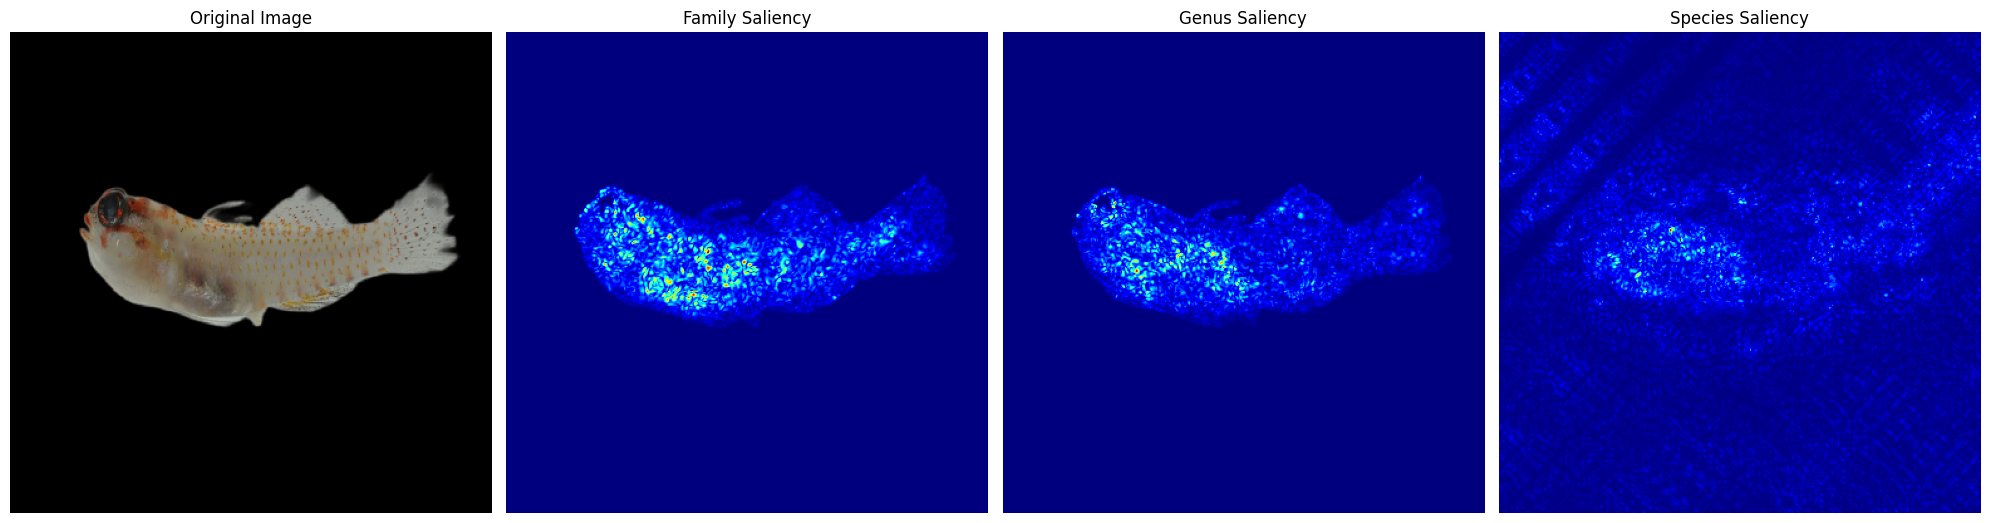

In [10]:
img_path = test_df['image_path'].values[3]

# Visualize saliency maps side-by-side
compute_saliency_maps(img_path, model)

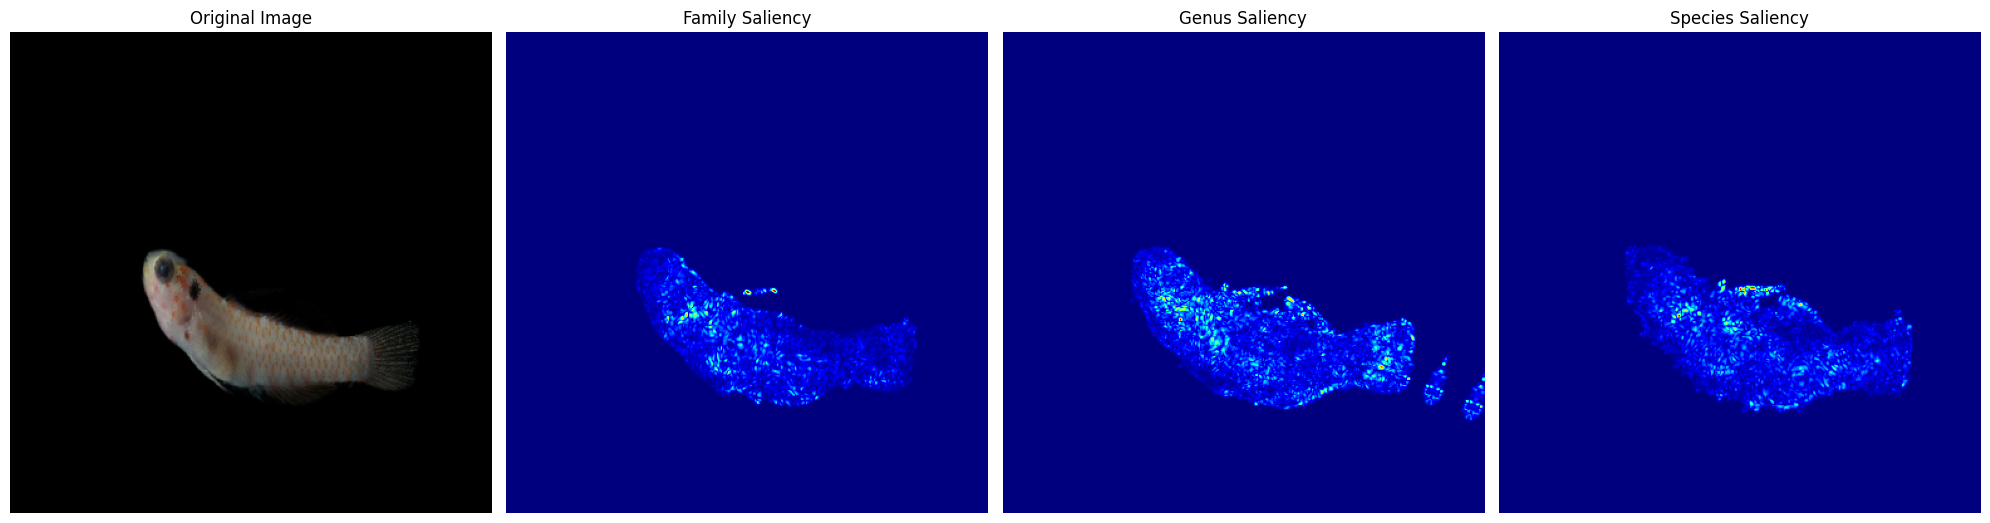

In [11]:
img_path = test_df['image_path'].values[384]

# Visualize saliency maps side-by-side
compute_saliency_maps(img_path, model)

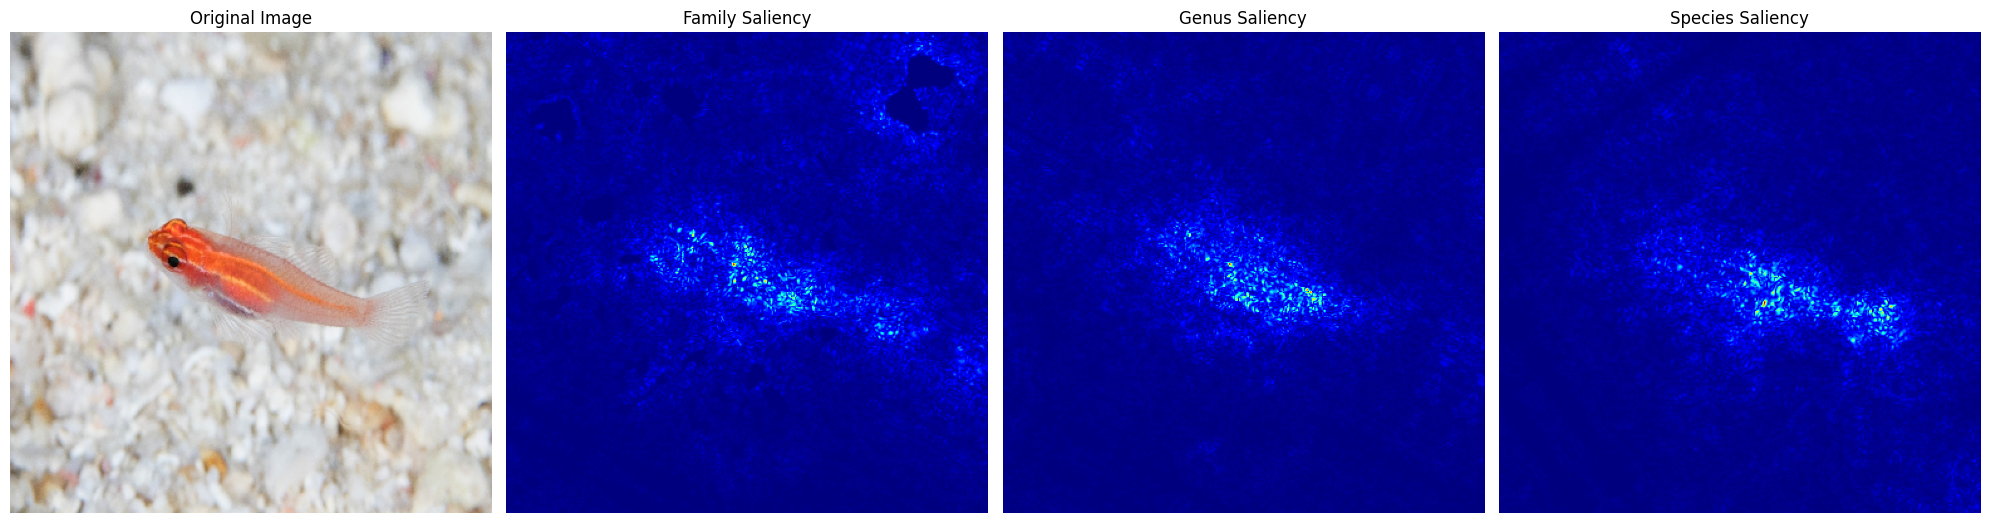

In [12]:
img_path = test_df['image_path'].values[689]

# Visualize saliency maps side-by-side
compute_saliency_maps(img_path, model)

## Full Analysis

In [5]:
from tqdm import tqdm  # Import tqdm for the progress bar

img_path = test_df['image_path'].values[0]

data = {
    'family': [],
    'family_confidence': [],
    'genus': [],
    'genus_confidence': [],
    'species': [],
    'species_confidence': [],
}

# Use tqdm to add a progress bar
for img_path in tqdm(test_df['image_path'].tolist(), desc="Processing Images", unit="image", colour="blue"):
    family_pred, genus_pred, species_pred = predict_image(
        img_path,
        model,
        family_labels,
        genus_labels,
        species_labels,
        image_size=(384, 384),
        top_k=1,
        verbose=0
    )
    
    data['family'].append(family_pred[0][0])
    data['family_confidence'].append(family_pred[0][1])
    data['genus'].append(genus_pred[0][0])
    data['genus_confidence'].append(genus_pred[0][1])
    data['species'].append(species_pred[0][0])
    data['species_confidence'].append(species_pred[0][1])
    
    
df_pred = pd.DataFrame(data)

Processing Images: 100%|██████████| 1354/1354 [01:37<00:00, 13.82image/s]


In [6]:
df_pred

family  family_confidence            genus  genus_confidence  \
0     Tetraodontidae           0.931152     Canthigaster          0.983887   
1           Gobiidae           0.699707    Nemateleotris          0.897461   
2      Pomacentridae           0.980957          Chromis          0.989746   
3           Gobiidae           0.867188           Eviota          0.926758   
4           Labridae           0.950684  Pseudocheilinus          0.959961   
...              ...                ...              ...               ...   
1349   Pomacentridae           0.860840          Chromis          0.501953   
1350        Gobiidae           0.987793    Nemateleotris          0.997559   
1351        Gobiidae           0.706543             Ucla          0.440186   
1352      Apogonidae           0.596680     Ostorhinchus          0.401123   
1353        Labridae           0.956543        Labroides          0.972656   

                         species  species_confidence  
0          Canthigaster solandri            0.993652  
1        Nemateleotris magnifica            0.963379  
2           Chromis margaritifer            0.982422  
3             Eviota albolineata            0.905762  
4     Pseudocheilinus hexataenia            0.917480  
...                          ...                 ...  
1349        Chromis margaritifer            0.612793  
1350     Nemateleotris magnifica            0.982422  
1351         Enneanectes matador            0.361084  
1352     Ostorhinchus angustatus            0.527344  
1353        Labroides dimidiatus            0.948242  

[1354 rows x 6 columns]

In [15]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("/Users/leonardo/Documents/Projects/cryptovision/models/phorcys_v09_hacpl_rn50v2_v2411251155.keras")

# Prepare datasets
df_images = image_directory_to_pandas(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/cv_images_dataset"
)

train_df, val_df, test_df = split_image_dataframe(
    df_images,
    val_size=0.15,
    test_size=0.15,
    random_state=42,
)

test_df.reset_index(drop=True, inplace=True)

family_labels = sorted(df_images['family'].unique())
genus_labels = sorted(df_images['genus'].unique())
species_labels = sorted(df_images['species'].unique())

test_ds, _, _, _ = build_dataset_from_dataframe(test_df, batch_size=64, image_size=(384, 384))


### Updated and Adapted Functions ###

def evaluate_model(test_ds, model, family_labels, genus_labels, species_labels, top_k=3):
    """
    Evaluate the model on a test dataset and calculate performance metrics.

    Parameters:
        test_ds (tf.data.Dataset): Test dataset
        model (tf.keras.Model): Trained model
        family_labels, genus_labels, species_labels (list): Unique labels
        top_k (int): Number of top predictions to consider

    Returns:
        None
    """
    all_true_families = []
    all_pred_families = []

    for batch in test_ds:
        images, labels = batch
        family_true = tf.argmax(labels['family'], axis=1).numpy()
        family_pred = tf.argmax(model.predict(images, verbose=0)[0], axis=1)
        
        print("Family True: ", family_true)
        print("Family Pred: ", family_pred)
        break

        all_true_families.extend(family_true)
        all_pred_families.extend(family_pred)

    print("\nFamily-level Evaluation")
    print("Confusion Matrix:")
    cm = confusion_matrix(all_true_families, all_pred_families)
    print(cm)

    print("\nClassification Report:")
    report = classification_report(all_true_families, all_pred_families, target_names=family_labels)
    print(report)

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix Heatmap')
    plt.colorbar()
    tick_marks = np.arange(len(family_labels))
    plt.xticks(tick_marks, family_labels, rotation=45)
    plt.yticks(tick_marks, family_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def evaluate_stability(test_df, model, family_labels, image_size=(384, 384), n_bootstraps=100):
    """
    Evaluate model stability using bootstrapping.

    Parameters:
        test_df (pd.DataFrame): Test DataFrame
        model (tf.keras.Model): Trained model
        family_labels (list): Unique family labels
        image_size (tuple): Target size for images
        n_bootstraps (int): Number of bootstrap samples

    Returns:
        None
    """
    accuracies = []
    for _ in range(n_bootstraps):
        bootstrap_df = test_df.sample(frac=1, replace=True)
        bootstrap_ds, _, _, _ = build_dataset_from_dataframe(bootstrap_df, image_size=image_size)

        all_true = []
        all_pred = []
        for batch in bootstrap_ds:
            images, labels = batch
            family_true = tf.argmax(labels['family'], axis=1).numpy()
            family_pred = tf.argmax(model.predict(images, verbose=0)[0], axis=1)
            all_true.extend(family_true)
            all_pred.extend(family_pred)

        accuracy = np.mean(np.array(all_true) == np.array(all_pred))
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    print(f"Bootstrap Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    plt.figure()
    plt.hist(accuracies, bins=20, color='skyblue', edgecolor='black')
    plt.title('Stability Assessment: Bootstrap Accuracy Distribution')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.show()


def evaluate_reliability_over_time(slices, model, family_labels, image_size=(384, 384)):
    """
    Evaluate model reliability over slices of test data.

    Parameters:
        slices (list of pd.DataFrame): List of DataFrame slices (e.g., time-based or subsets)
        model (tf.keras.Model): Trained model
        family_labels (list): Unique family labels
        image_size (tuple): Target size for images

    Returns:
        None
    """
    accuracies = []

    for slice_df in slices:
        slice_ds, _, _, _ = build_dataset_from_dataframe(slice_df, image_size=image_size)

        all_true = []
        all_pred = []
        for batch in slice_ds:
            images, labels = batch
            family_true = tf.argmax(labels['family'], axis=1).numpy()
            family_pred = tf.argmax(model.predict(images, verbose=0)[0], axis=1)
            all_true.extend(family_true)
            all_pred.extend(family_pred)

        accuracy = np.mean(np.array(all_true) == np.array(all_pred))
        accuracies.append(accuracy)

    plt.figure()
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o')
    plt.title('Model Reliability Over Time/Slices')
    plt.xlabel('Slice Index')
    plt.ylabel('Accuracy')
    plt.show()



/Users/leonardo/miniconda3/envs/cvenv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 98 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:

### Example Usage ###
# Evaluate model on test dataset
evaluate_model(test_ds, model, family_labels, genus_labels, species_labels)

# Evaluate stability using bootstrapping
#evaluate_stability(test_df, model, family_labels)

# Evaluate reliability over time slices
# Assuming you have split test_df into time-based or other slices
# time_slices = [test_df_time1, test_df_time2, ...]
# evaluate_reliability_over_time(time_slices, model, family_labels)

Family True:  [16 17  6  9  9 15  3 15  8 15  6  0  9  6  1 13 15 16  3  7  6  6  7  0
 17  7  6  6  6 16  7  6 17  8 10  4  6  6  7 10 10  9  6  6  7  6 11  6
  7  0  6  6  6  6 12  6  1  6  6  9  6  3  4  7]
Family Pred:  tf.Tensor(
[16 17  6  9  9 15  3 15  8 15  6  0  9  6  1 13 15 16  3  7  6  6  7  0
 17  7  6  6  6 16  7  6 17  1 10  4  6  6  9 10 10  9  6  6  7  6  6  6
  7  0  6  6  6  6  0  6  1  6  6  9  6  3  4  7], shape=(64,), dtype=int64)

Family-level Evaluation
Confusion Matrix:
[]

Classification Report:


ValueError: Number of classes, 0, does not match size of target_names, 18. Try specifying the labels parameter

In [21]:
evaluate_stability(test_df, model, family_labels, n_bootstraps=10)

KeyboardInterrupt: 

In [23]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_per_class_metrics(test_ds, model, family_labels, genus_labels, species_labels):
    """
    Evaluate accuracy, precision, recall, and support for each class across Family, Genus, and Species predictions.

    Parameters:
        test_ds (tf.data.Dataset): Test dataset
        model (tf.keras.Model): Trained model
        family_labels, genus_labels, species_labels (list): Unique labels for Family, Genus, and Species

    Returns:
        metrics_summary (dict): Dictionary containing metrics for Family, Genus, and Species
    """
    all_true_families = []
    all_pred_families = []
    all_true_genus = []
    all_pred_genus = []
    all_true_species = []
    all_pred_species = []

    # Collect all predictions and true labels
    for batch in test_ds:
        images, labels = batch
        family_true = tf.argmax(labels['family'], axis=1).numpy()
        genus_true = tf.argmax(labels['genus'], axis=1).numpy()
        species_true = tf.argmax(labels['species'], axis=1).numpy()

        preds = model.predict(images, verbose=0)
        family_pred = tf.argmax(preds[0], axis=1).numpy()
        genus_pred = tf.argmax(preds[1], axis=1).numpy()
        species_pred = tf.argmax(preds[2], axis=1).numpy()

        all_true_families.extend(family_true)
        all_pred_families.extend(family_pred)
        all_true_genus.extend(genus_true)
        all_pred_genus.extend(genus_pred)
        all_true_species.extend(species_true)
        all_pred_species.extend(species_pred)

    # Helper function to calculate metrics per class
    def calculate_metrics_per_class(y_true, y_pred, labels):
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, labels=range(len(labels)))
        accuracy = accuracy_score(y_true, y_pred)
        metrics = pd.DataFrame({
            'Class': labels,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Support': support
        }).set_index('Class')
        return metrics, accuracy

    # Calculate metrics for each output
    family_metrics, family_accuracy = calculate_metrics_per_class(all_true_families, all_pred_families, family_labels)
    genus_metrics, genus_accuracy = calculate_metrics_per_class(all_true_genus, all_pred_genus, genus_labels)
    species_metrics, species_accuracy = calculate_metrics_per_class(all_true_species, all_pred_species, species_labels)

    # Display and summarize results
    print("\nFamily-Level Metrics")
    print(f"Accuracy: {family_accuracy:.4f}")
    display(family_metrics)

    print("\nGenus-Level Metrics")
    print(f"Accuracy: {genus_accuracy:.4f}")
    display(genus_metrics)

    print("\nSpecies-Level Metrics")
    print(f"Accuracy: {species_accuracy:.4f}")
    display(species_metrics)

    # Summarize results in a dictionary
    metrics_summary = {
        'Family': {'metrics': family_metrics, 'accuracy': family_accuracy},
        'Genus': {'metrics': genus_metrics, 'accuracy': genus_accuracy},
        'Species': {'metrics': species_metrics, 'accuracy': species_accuracy}
    }

    return metrics_summary

# Example usage
metrics_summary = evaluate_per_class_metrics(test_ds, model, family_labels, genus_labels, species_labels)


Family-Level Metrics
Accuracy: 0.9594


Precision    Recall  F1-Score  Support
Class                                                  
Apogonidae        0.963636  0.963636  0.963636      110
Blenniidae        0.921569  0.921569  0.921569       51
Chaenopsidae      0.818182  0.692308  0.750000       13
Chaetodontidae    1.000000  1.000000  1.000000       53
Cirrhitidae       0.972973  1.000000  0.986301       36
Creediidae        1.000000  0.625000  0.769231        8
Gobiidae          0.964194  0.966667  0.965429      390
Labridae          0.985294  0.937063  0.960573      143
Plesiopidae       0.857143  0.857143  0.857143       14
Pomacanthidae     0.955556  1.000000  0.977273       86
Pomacentridae     0.956140  0.981982  0.968889      111
Pseudochromidae   0.954545  0.840000  0.893617       25
Sciaenidae        1.000000  0.750000  0.857143        8
Scorpaenidae      0.929825  1.000000  0.963636       53
Serranidae        1.000000  0.941176  0.969697       17
Syngnathidae      0.988095  0.954023  0.970760       87
Tetraodontidae    0.986842  1.000000  0.993377       75
Tripterygiidae    0.876543  0.959459  0.916129       74


Genus-Level Metrics
Accuracy: 0.9468


Precision    Recall  F1-Score  Support
Class                                                   
Acanthemblemaria   0.722222  1.000000  0.838710       13
Aioliops           1.000000  1.000000  1.000000       12
Apogon             0.977778  1.000000  0.988764       44
Canthigaster       1.000000  1.000000  1.000000       75
Caracanthus        1.000000  0.966667  0.983051       30
Centropyge         0.964286  1.000000  0.981818       27
Chaetodon          1.000000  1.000000  1.000000       53
Chromis            0.965517  0.965517  0.965517       58
Cirripectes        0.888889  1.000000  0.941176       16
Corythoichthys     1.000000  0.983333  0.991597       60
Cypho              1.000000  0.880000  0.936170       25
Doryrhamphus       0.931034  1.000000  0.964286       27
Ecsenius           0.920000  0.884615  0.901961       26
Enchelyurus        0.875000  0.777778  0.823529        9
Enneanectes        0.888889  0.727273  0.800000       11
Enneapterygius     0.833333  0.972222  0.897436       36
Eques              1.000000  0.750000  0.857143        8
Eviota             0.956522  0.897959  0.926316       49
Fowleria           1.000000  0.700000  0.823529       10
Fusigobius         0.846154  1.000000  0.916667       33
Gobiodon           0.891892  0.942857  0.916667       35
Gomphosus          1.000000  0.823529  0.903226       17
Halichoeres        0.947368  0.947368  0.947368       19
Helcogramma        1.000000  0.777778  0.875000        9
Istigobius         0.983871  0.938462  0.960630       65
Koumansetta        0.971429  0.918919  0.944444       37
Labroides          0.935484  0.906250  0.920635       32
Limnichthys        1.000000  0.750000  0.857143        8
Nemateleotris      0.990000  0.990000  0.990000      100
Neocirrhites       0.950000  0.950000  0.950000       20
Ostorhinchus       0.948718  1.000000  0.973684       37
Paracirrhites      0.937500  0.937500  0.937500       16
Paragobiodon       0.947368  0.818182  0.878049       22
Plesiops           1.000000  0.928571  0.962963       14
Pleurosicya        0.625000  0.625000  0.625000        8
Pomacanthus        0.966667  0.983051  0.974790       59
Pomacentrus        0.896552  0.981132  0.936937       53
Priolepis          1.000000  0.882353  0.937500       17
Pristiapogon       1.000000  1.000000  1.000000       19
Pseudocheilinus    0.973333  0.973333  0.973333       75
Pseudogramma       1.000000  0.941176  0.969697       17
Scorpaenodes       1.000000  0.777778  0.875000        9
Sebastapistes      0.823529  1.000000  0.903226       14
Trimma             1.000000  0.750000  0.857143       12
Ucla               0.625000  0.833333  0.714286       18


Species-Level Metrics
Accuracy: 0.9402


Precision    Recall  F1-Score  Support
Class                                                                
Acanthemblemaria aspera         0.928571  1.000000  0.962963       13
Aioliops megastigma             1.000000  1.000000  1.000000       12
Apogon binotatus                1.000000  1.000000  1.000000       19
Apogon maculatus                0.892857  1.000000  0.943396       25
Canthigaster solandri           0.986842  1.000000  0.993377       75
Caracanthus maculatus           1.000000  1.000000  1.000000       20
Caracanthus unipinna            1.000000  1.000000  1.000000       10
Centropyge bispinosa            0.947368  1.000000  0.972973       18
Centropyge flavissima           0.900000  1.000000  0.947368        9
Chaetodon quadrimaculatus       1.000000  1.000000  1.000000       53
Chromis margaritifer            0.965517  0.965517  0.965517       58
Cirripectes variolosus          0.714286  0.937500  0.810811       16
Corythoichthys flavofasciatus   0.983333  0.983333  0.983333       60
Cypho purpurascens              1.000000  0.880000  0.936170       25
Doryrhamphus excisus            0.964286  1.000000  0.981818       27
Ecsenius pulcher                0.777778  0.636364  0.700000       11
Ecsenius stictus                0.923077  0.800000  0.857143       15
Enchelyurus ater                1.000000  0.666667  0.800000        9
Enneanectes matador             0.687500  1.000000  0.814815       11
Enneapterygius pyramis          1.000000  1.000000  1.000000       10
Enneapterygius tutuilae         0.937500  0.937500  0.937500       16
Enneapterygius ventermaculus    0.909091  1.000000  0.952381       10
Eques punctatus                 1.000000  0.875000  0.933333        8
Eviota albolineata              0.764706  0.928571  0.838710       14
Eviota atriventris              0.947368  0.900000  0.923077       20
Eviota melasma                  0.727273  0.533333  0.615385       15
Fowleria vaiulae                1.000000  0.600000  0.750000       10
Fusigobius neophytus            0.888889  0.969697  0.927536       33
Gobiodon histrio                0.809524  0.850000  0.829268       20
Gobiodon quinquestrigatus       0.882353  1.000000  0.937500       15
Gomphosus varius                1.000000  0.882353  0.937500       17
Halichoeres claudia             0.947368  0.947368  0.947368       19
Helcogramma fuscopinna          0.875000  0.777778  0.823529        9
Istigobius decoratus            0.938462  0.938462  0.938462       65
Koumansetta rainfordi           0.971429  0.918919  0.944444       37
Labroides dimidiatus            0.935484  0.906250  0.920635       32
Limnichthys nitidus             1.000000  0.875000  0.933333        8
Nemateleotris magnifica         0.990000  0.990000  0.990000      100
Neocirrhites armatus            0.947368  0.900000  0.923077       20
Ostorhinchus angustatus         0.973684  1.000000  0.986667       37
Paracirrhites arcatus           0.833333  0.937500  0.882353       16
Paragobiodon lacunicolus        1.000000  0.700000  0.823529       10
Paragobiodon modestus           1.000000  0.916667  0.956522       12
Plesiops coeruleolineatus       1.000000  0.928571  0.962963       14
Pleurosicya labiata             0.750000  0.750000  0.750000        8
Pomacanthus maculosus           0.966667  0.983051  0.974790       59
Pomacentrus amboinensis         0.928571  1.000000  0.962963       13
Pomacentrus pavo                0.951220  0.975000  0.962963       40
Priolepis semidoliatus          1.000000  0.941176  0.969697       17
Pristiapogon kallopterus        1.000000  1.000000  1.000000       19
Pseudocheilinus hexataenia      0.933333  0.965517  0.949153       58
Pseudocheilinus tetrataenia     0.812500  0.764706  0.787879       17
Pseudogramma polyacantha        1.000000  0.941176  0.969697       17
Scorpaenodes kelloggi           0.875000  0.777778  0.823529        9
Sebastapistes fowleri           0.866667  0.928571  0.896552       14
Trimma macrophthalmus           1.000000 

In [18]:
def generate_hierarchy_map(test_df):
    """
    Generate a hierarchy map from the test_df DataFrame.
    
    The hierarchy is based on the columns: 'family', 'genus', and 'species'.
    
    Parameters:
        test_df (pd.DataFrame): DataFrame containing 'family', 'genus', and 'species' columns.
        
    Returns:
        hierarchy_map (dict): A nested dictionary representing the hierarchy.
    """
    hierarchy_map = {}
    
    # Iterate through unique families
    for family in test_df['family'].unique():
        family_genus_map = {}
        
        # Filter rows belonging to the current family
        family_df = test_df[test_df['family'] == family]
        
        # Iterate through unique genera within the family
        for genus in family_df['genus'].unique():
            # Filter rows belonging to the current genus
            genus_df = family_df[family_df['genus'] == genus]
            
            # Collect all unique species within the genus
            species_list = list(genus_df['species'].unique())
            
            # Add genus and its species to the family map
            family_genus_map[genus] = species_list
        
        # Add family and its genus map to the hierarchy map
        hierarchy_map[family] = family_genus_map
    
    return hierarchy_map

# Example Usage
hierarchy_map = generate_hierarchy_map(test_df)
print("Generated Hierarchy Map:")
import pprint
pprint.pprint(hierarchy_map)

Generated Hierarchy Map:
{'Apogonidae': {'Apogon': ['Apogon binotatus', 'Apogon maculatus'],
                'Fowleria': ['Fowleria vaiulae'],
                'Ostorhinchus': ['Ostorhinchus angustatus'],
                'Pristiapogon': ['Pristiapogon kallopterus']},
 'Blenniidae': {'Cirripectes': ['Cirripectes variolosus'],
                'Ecsenius': ['Ecsenius stictus', 'Ecsenius pulcher'],
                'Enchelyurus': ['Enchelyurus ater']},
 'Chaenopsidae': {'Acanthemblemaria': ['Acanthemblemaria aspera']},
 'Chaetodontidae': {'Chaetodon': ['Chaetodon quadrimaculatus']},
 'Cirrhitidae': {'Neocirrhites': ['Neocirrhites armatus'],
                 'Paracirrhites': ['Paracirrhites arcatus']},
 'Creediidae': {'Limnichthys': ['Limnichthys nitidus']},
 'Gobiidae': {'Aioliops': ['Aioliops megastigma'],
              'Eviota': ['Eviota albolineata',
                         'Eviota atriventris',
                         'Eviota melasma'],
              'Fusigobius': ['Fusigobius neophytus

In [25]:
def generate_model_performance_report(
    test_ds,
    model,
    family_labels,
    genus_labels,
    species_labels,
    test_df,
    image_size=(384, 384),
    n_bootstraps=100
):
    """
    Generate a comprehensive performance report for the trained model.

    Parameters:
        test_ds (tf.data.Dataset): Test dataset
        model (tf.keras.Model): Trained model
        family_labels, genus_labels, species_labels (list): Unique labels for Family, Genus, and Species
        test_df (pd.DataFrame): DataFrame containing test data
        image_size (tuple): Image size for evaluation
        n_bootstraps (int): Number of bootstrap samples for stability evaluation

    Returns:
        report (dict): A dictionary summarizing the performance report
    """
    report = {}

    ### Overall Accuracy ###
    print("Calculating overall accuracy...")
    all_true_families = []
    all_pred_families = []
    for batch in test_ds:
        images, labels = batch
        family_true = tf.argmax(labels['family'], axis=1).numpy()
        family_pred = tf.argmax(model.predict(images, verbose=0)[0], axis=1)
        all_true_families.extend(family_true)
        all_pred_families.extend(family_pred)

    overall_accuracy = np.mean(np.array(all_true_families) == np.array(all_pred_families))
    print(f"Overall Accuracy (Family-level): {overall_accuracy:.4f}")
    report['overall_accuracy'] = overall_accuracy

    ### Per-Class Metrics ###
    print("Calculating per-class metrics...")
    family_metrics, _ = evaluate_per_class_metrics(test_ds, model, family_labels, genus_labels, species_labels)
    report['family_metrics'] = family_metrics

    ### Stability Analysis ###
    print("Calculating stability metrics using bootstrapping...")
    accuracies = []
    for _ in range(n_bootstraps):
        bootstrap_df = test_df.sample(frac=1, replace=True)
        bootstrap_ds, _, _, _ = build_dataset_from_dataframe(bootstrap_df, image_size=image_size)

        all_true = []
        all_pred = []
        for batch in bootstrap_ds:
            images, labels = batch
            family_true = tf.argmax(labels['family'], axis=1).numpy()
            family_pred = tf.argmax(model.predict(images, verbose=0)[0], axis=1)
            all_true.extend(family_true)
            all_pred.extend(family_pred)

        accuracy = np.mean(np.array(all_true) == np.array(all_pred))
        accuracies.append(accuracy)

    mean_stability = np.mean(accuracies)
    std_stability = np.std(accuracies)
    print(f"Stability (Bootstrap Accuracy): {mean_stability:.4f} ± {std_stability:.4f}")
    report['stability'] = {
        'mean_accuracy': mean_stability,
        'std_accuracy': std_stability,
    }

    ### Final Report Summary ###
    print("\nModel Performance Report Summary:")
    print(f"- Overall Accuracy: {overall_accuracy:.4f}")
    print(f"- Stability: {mean_stability:.4f} ± {std_stability:.4f}")

    return report

In [26]:
performance_report = generate_model_performance_report(
    test_ds=test_ds,
    model=model,
    family_labels=family_labels,
    genus_labels=genus_labels,
    species_labels=species_labels,
    test_df=test_df,
    n_bootstraps=20
)

Calculating overall accuracy...
Overall Accuracy (Family-level): 0.9594
Calculating per-class metrics...

Family-Level Metrics
Accuracy: 0.9594


Precision    Recall  F1-Score  Support
Class                                                  
Apogonidae        0.963636  0.963636  0.963636      110
Blenniidae        0.921569  0.921569  0.921569       51
Chaenopsidae      0.818182  0.692308  0.750000       13
Chaetodontidae    1.000000  1.000000  1.000000       53
Cirrhitidae       0.972973  1.000000  0.986301       36
Creediidae        1.000000  0.625000  0.769231        8
Gobiidae          0.964194  0.966667  0.965429      390
Labridae          0.985294  0.937063  0.960573      143
Plesiopidae       0.857143  0.857143  0.857143       14
Pomacanthidae     0.955556  1.000000  0.977273       86
Pomacentridae     0.956140  0.981982  0.968889      111
Pseudochromidae   0.954545  0.840000  0.893617       25
Sciaenidae        1.000000  0.750000  0.857143        8
Scorpaenidae      0.929825  1.000000  0.963636       53
Serranidae        1.000000  0.941176  0.969697       17
Syngnathidae      0.988095  0.954023  0.970760       87
Tetraodontidae    0.986842  1.000000  0.993377       75
Tripterygiidae    0.876543  0.959459  0.916129       74


Genus-Level Metrics
Accuracy: 0.9468


Precision    Recall  F1-Score  Support
Class                                                   
Acanthemblemaria   0.722222  1.000000  0.838710       13
Aioliops           1.000000  1.000000  1.000000       12
Apogon             0.977778  1.000000  0.988764       44
Canthigaster       1.000000  1.000000  1.000000       75
Caracanthus        1.000000  0.966667  0.983051       30
Centropyge         0.964286  1.000000  0.981818       27
Chaetodon          1.000000  1.000000  1.000000       53
Chromis            0.965517  0.965517  0.965517       58
Cirripectes        0.888889  1.000000  0.941176       16
Corythoichthys     1.000000  0.983333  0.991597       60
Cypho              1.000000  0.880000  0.936170       25
Doryrhamphus       0.931034  1.000000  0.964286       27
Ecsenius           0.920000  0.884615  0.901961       26
Enchelyurus        0.875000  0.777778  0.823529        9
Enneanectes        0.888889  0.727273  0.800000       11
Enneapterygius     0.833333  0.972222  0.897436       36
Eques              1.000000  0.750000  0.857143        8
Eviota             0.956522  0.897959  0.926316       49
Fowleria           1.000000  0.700000  0.823529       10
Fusigobius         0.846154  1.000000  0.916667       33
Gobiodon           0.891892  0.942857  0.916667       35
Gomphosus          1.000000  0.823529  0.903226       17
Halichoeres        0.947368  0.947368  0.947368       19
Helcogramma        1.000000  0.777778  0.875000        9
Istigobius         0.983871  0.938462  0.960630       65
Koumansetta        0.971429  0.918919  0.944444       37
Labroides          0.935484  0.906250  0.920635       32
Limnichthys        1.000000  0.750000  0.857143        8
Nemateleotris      0.990000  0.990000  0.990000      100
Neocirrhites       0.950000  0.950000  0.950000       20
Ostorhinchus       0.948718  1.000000  0.973684       37
Paracirrhites      0.937500  0.937500  0.937500       16
Paragobiodon       0.947368  0.818182  0.878049       22
Plesiops           1.000000  0.928571  0.962963       14
Pleurosicya        0.625000  0.625000  0.625000        8
Pomacanthus        0.966667  0.983051  0.974790       59
Pomacentrus        0.896552  0.981132  0.936937       53
Priolepis          1.000000  0.882353  0.937500       17
Pristiapogon       1.000000  1.000000  1.000000       19
Pseudocheilinus    0.973333  0.973333  0.973333       75
Pseudogramma       1.000000  0.941176  0.969697       17
Scorpaenodes       1.000000  0.777778  0.875000        9
Sebastapistes      0.823529  1.000000  0.903226       14
Trimma             1.000000  0.750000  0.857143       12
Ucla               0.625000  0.833333  0.714286       18


Species-Level Metrics
Accuracy: 0.9402


Precision    Recall  F1-Score  Support
Class                                                                
Acanthemblemaria aspera         0.928571  1.000000  0.962963       13
Aioliops megastigma             1.000000  1.000000  1.000000       12
Apogon binotatus                1.000000  1.000000  1.000000       19
Apogon maculatus                0.892857  1.000000  0.943396       25
Canthigaster solandri           0.986842  1.000000  0.993377       75
Caracanthus maculatus           1.000000  1.000000  1.000000       20
Caracanthus unipinna            1.000000  1.000000  1.000000       10
Centropyge bispinosa            0.947368  1.000000  0.972973       18
Centropyge flavissima           0.900000  1.000000  0.947368        9
Chaetodon quadrimaculatus       1.000000  1.000000  1.000000       53
Chromis margaritifer            0.965517  0.965517  0.965517       58
Cirripectes variolosus          0.714286  0.937500  0.810811       16
Corythoichthys flavofasciatus   0.983333  0.983333  0.983333       60
Cypho purpurascens              1.000000  0.880000  0.936170       25
Doryrhamphus excisus            0.964286  1.000000  0.981818       27
Ecsenius pulcher                0.777778  0.636364  0.700000       11
Ecsenius stictus                0.923077  0.800000  0.857143       15
Enchelyurus ater                1.000000  0.666667  0.800000        9
Enneanectes matador             0.687500  1.000000  0.814815       11
Enneapterygius pyramis          1.000000  1.000000  1.000000       10
Enneapterygius tutuilae         0.937500  0.937500  0.937500       16
Enneapterygius ventermaculus    0.909091  1.000000  0.952381       10
Eques punctatus                 1.000000  0.875000  0.933333        8
Eviota albolineata              0.764706  0.928571  0.838710       14
Eviota atriventris              0.947368  0.900000  0.923077       20
Eviota melasma                  0.727273  0.533333  0.615385       15
Fowleria vaiulae                1.000000  0.600000  0.750000       10
Fusigobius neophytus            0.888889  0.969697  0.927536       33
Gobiodon histrio                0.809524  0.850000  0.829268       20
Gobiodon quinquestrigatus       0.882353  1.000000  0.937500       15
Gomphosus varius                1.000000  0.882353  0.937500       17
Halichoeres claudia             0.947368  0.947368  0.947368       19
Helcogramma fuscopinna          0.875000  0.777778  0.823529        9
Istigobius decoratus            0.938462  0.938462  0.938462       65
Koumansetta rainfordi           0.971429  0.918919  0.944444       37
Labroides dimidiatus            0.935484  0.906250  0.920635       32
Limnichthys nitidus             1.000000  0.875000  0.933333        8
Nemateleotris magnifica         0.990000  0.990000  0.990000      100
Neocirrhites armatus            0.947368  0.900000  0.923077       20
Ostorhinchus angustatus         0.973684  1.000000  0.986667       37
Paracirrhites arcatus           0.833333  0.937500  0.882353       16
Paragobiodon lacunicolus        1.000000  0.700000  0.823529       10
Paragobiodon modestus           1.000000  0.916667  0.956522       12
Plesiops coeruleolineatus       1.000000  0.928571  0.962963       14
Pleurosicya labiata             0.750000  0.750000  0.750000        8
Pomacanthus maculosus           0.966667  0.983051  0.974790       59
Pomacentrus amboinensis         0.928571  1.000000  0.962963       13
Pomacentrus pavo                0.951220  0.975000  0.962963       40
Priolepis semidoliatus          1.000000  0.941176  0.969697       17
Pristiapogon kallopterus        1.000000  1.000000  1.000000       19
Pseudocheilinus hexataenia      0.933333  0.965517  0.949153       58
Pseudocheilinus tetrataenia     0.812500  0.764706  0.787879       17
Pseudogramma polyacantha        1.000000  0.941176  0.969697       17
Scorpaenodes kelloggi           0.875000  0.777778  0.823529        9
Sebastapistes fowleri           0.866667  0.928571  0.896552       14
Trimma macrophthalmus           1.000000 

ValueError: too many values to unpack (expected 2)